In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import tensorflow 
import nltk

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.utils import to_categorical 
from tensorflow.python.framework.random_seed import set_random_seed

from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 
from keras.callbacks import EarlyStopping 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from nltk.corpus import stopwords

data_url = 'https://www.math.unipd.it/~dasan/disaster/'
train_csv = pd.read_csv(data_url + 'train.csv', sep=",") 
test_csv = pd.read_csv(data_url + 'test.csv', sep=",") 



In [ ]:
def download_predictions_to_file(id_array, predictions_array):
  # This function, given a numpy array with the ids of the test tweets and a numpy array with the corresponding predictions, 
  # creates and let's you download a prediction file suitable to be uploaded to the Kaggle website

  id_array = id_array.reshape(len(id_array),1) # making sure the arrays are of the size requested by hstack(), i.e. (x,1) instead of (x,) 
  predictions_array = predictions_array.reshape(len(predictions_array),1)

  from google.colab import files
  result = pd.DataFrame(np.hstack((id_array, predictions_array)), columns=['id','target'])
  result.to_csv('prediction_file.csv', index=False)
  files.download('prediction_file.csv')

X_test_id = test_csv["id"].values


In [ ]:
#let's take a look at the data
print(train_csv.head())
print(test_csv.head())

#we have 5 features: id, keyword, location, text, target
print(train_csv.columns)
print()

#let's see if we have missing values
print(train_csv.isnull().sum())
print()
print(test_csv.isnull().sum())

   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')



In [ ]:
#we discard id, location and keyword columns
Y_train = train_csv.filter(['target'], axis = 1)
X_train = train_csv.filter(['text'], axis=1)
print(X_train.head())
print()

X_test = test_csv.filter(['text'], axis=1)
print(X_test.head())

                                                text
0  Our Deeds are the Reason of this #earthquake M...
1             Forest fire near La Ronge Sask. Canada
2  All residents asked to 'shelter in place' are ...
3  13,000 people receive #wildfires evacuation or...
4  Just got sent this photo from Ruby #Alaska as ...

                                                text
0                 Just happened a terrible car crash
1  Heard about #earthquake is different cities, s...
2  there is a forest fire at spot pond, geese are...
3           Apocalypse lighting. #Spokane #wildfires
4      Typhoon Soudelor kills 28 in China and Taiwan


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


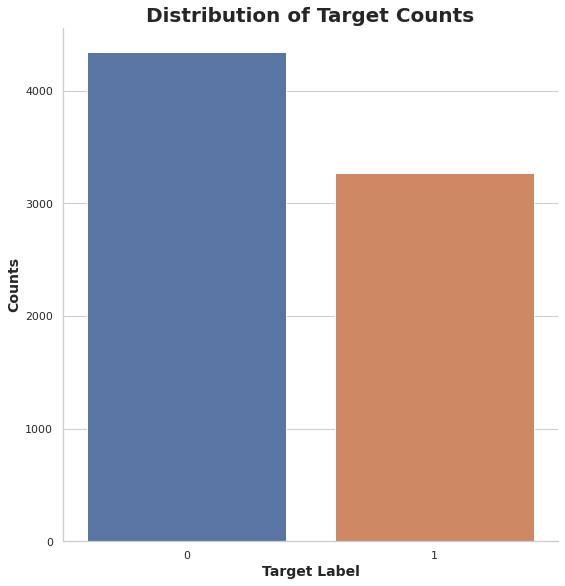

In [ ]:
# counting the number of positive and negative tweets
sns.set(style="whitegrid", color_codes=True)
sns.catplot("target", data=train_csv, kind="count", height=8)
plt.title("Distribution of Target Counts", size=20, weight="bold")
plt.xlabel("Target Label", size=14, weight="bold")
plt.ylabel("Counts", size=14, weight="bold")
plt.show()

In [ ]:
#Clean the text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


def lower_text(text):
    return text.lower()

# Applying helper functions
X_train['text'] = X_train['text'].apply(lambda x: remove_URL(x))
X_train['text'] = X_train['text'].apply(lambda x: remove_emoji(x))
X_train['text'] = X_train['text'].apply(lambda x: remove_html(x))
X_train['text'] = X_train['text'].apply(lambda x: remove_punct(x))
X_train['text'] = X_train['text'].apply(lambda x: lower_text(x))
X_train['text'] = X_train['text'].apply(lambda x:re.sub('\w*\d\w*' , '', x) ) #remove words containing numbers

X_test['text'] = X_test['text'].apply(lambda x: remove_URL(x))
X_test['text'] = X_test['text'].apply(lambda x: remove_emoji(x))
X_test['text'] = X_test['text'].apply(lambda x: remove_html(x))
X_test['text'] = X_test['text'].apply(lambda x: remove_punct(x))
X_test['text'] = X_test['text'].apply(lambda x: lower_text(x))
X_test['text'] = X_test['text'].apply(lambda x:re.sub('\w*\d\w*', '', x) )

print(X_train.head())
print()
print(X_test.head())

                                                text
0  our deeds are the reason of this earthquake ma...
1              forest fire near la ronge sask canada
2  all residents asked to shelter in place are be...
3   people receive wildfires evacuation orders in...
4  just got sent this photo from ruby alaska as s...

                                                text
0                 just happened a terrible car crash
1  heard about earthquake is different cities sta...
2  there is a forest fire at spot pond geese are ...
3              apocalypse lighting spokane wildfires
4        typhoon soudelor kills  in china and taiwan


In [ ]:
#Tokenizer
token=nltk.tokenize.RegexpTokenizer(r'\w+')
#applying token
X_train['text'] = X_train['text'].apply(lambda x:token.tokenize(x))
X_test['text'] = X_test['text'].apply(lambda x:token.tokenize(x))
#view
print(X_train['text'].head())
print()
print(X_test['text'].head())



0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

0            [just, happened, a, terrible, car, crash]
1    [heard, about, earthquake, is, different, citi...
2    [there, is, a, forest, fire, at, spot, pond, g...
3           [apocalypse, lighting, spokane, wildfires]
4    [typhoon, soudelor, kills, in, china, and, tai...
Name: text, dtype: object


In [ ]:
nltk.download('stopwords')
#removing stop words
X_train['text'] = X_train['text'].apply(lambda x:[w for w in x if w not in stopwords.words('english')])
X_test['text'] = X_test['text'].apply(lambda x:[w for w in x if w not in stopwords.words('english')])
#view
print(X_train['text'].head())
print()
print(X_test['text'].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

0                     [happened, terrible, car, crash]
1    [heard, earthquake, different, cities, stay, s...
2    [forest, fire, spot, pond, geese, fleeing, acr...
3           [apocalypse, lighting, spokane, wildfires]
4            [typhoon, soudelor, kills, china, taiwan]
Name: text, dtype: object


In [ ]:
#stemmering the text and joining
stemmer = nltk.stem.PorterStemmer()
X_train['text'] = X_train['text'].apply(lambda x:" ".join(stemmer.stem(token) for token in x))
X_test['text'] = X_test['text'].apply(lambda x:" ".join(stemmer.stem(token) for token in x))
#View
print(X_train['text'].head())
print()
print(X_test['text'].head())
print(X_test.shape)

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3          peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
Name: text, dtype: object

0                             happen terribl car crash
1        heard earthquak differ citi stay safe everyon
2    forest fire spot pond gees flee across street ...
3                       apocalyps light spokan wildfir
4                   typhoon soudelor kill china taiwan
Name: text, dtype: object
(3263, 1)


In [ ]:
count_vectorizer = CountVectorizer(max_features=2000, max_df=0.90)
X_train_val_count = count_vectorizer.fit_transform(X_train['text']) 
X_test_count = count_vectorizer.transform(X_test["text"])

print("vocabulary size:", len(count_vectorizer.vocabulary_))
print(X_train_val_count.shape)


vocabulary size: 2000
(7613, 2000)


In [ ]:
# Split the train+validation into 80% train and 20% validation subsets
Y_train_val = Y_train
x_train, x_val, y_train, y_val = train_test_split(X_train_val_count, Y_train_val, test_size=0.2, random_state= 123, stratify=Y_train_val)


In [ ]:
#define the scaler
scalerAbs = MaxAbsScaler()

#fit the scaler
scalerAbs.fit(x_train)

X_train_sclabs = scalerAbs.transform(x_train)
X_val_sclabs = scalerAbs.transform(x_val)
X_test_sclabs = scalerAbs.transform(X_test_count) 

#target classifier
lr = LogisticRegression(random_state=123)
param_grid_test = {'C': [0.1, 0.5, 1],'fit_intercept': [True, False]}

#grid-search object
clf = GridSearchCV(estimator= lr, param_grid=param_grid_test, n_jobs=-1, cv = 5, scoring = "f1")

clf.fit(X_train_sclabs, y_train.values.ravel()) #ravel() is to return a 1d array

# #see the best parameters and performance
print(f"Best parameters for logistic regression are: {clf.best_params_}\n")

y_train_lr = clf.predict(X_train_sclabs)
print(f"F1 score for this training set using best parameters: {f1_score(y_train, y_train_lr, average = 'macro')}")
y_val_lr = clf.predict(X_val_sclabs)
f1_score_lr = f1_score(y_val, y_val_lr, average = 'macro')
print(f"F1 score for this validation set using best parameters: {f1_score_lr}\n") 


results_df = pd.DataFrame(clf.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

Best parameters for logistic regression are: {'C': 0.5, 'fit_intercept': False}

F1 score for this training set using best parameters: 0.8560932313774154
F1 score for this validation set using best parameters: 0.7621226526955092



,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
0.5_False,"{'C': 0.5, 'fit_intercept': False}",1,0.744022,0.012294
0.1_False,"{'C': 0.1, 'fit_intercept': False}",2,0.740089,0.015851
1_False,"{'C': 1, 'fit_intercept': False}",3,0.735805,0.007898
0.5_True,"{'C': 0.5, 'fit_intercept': True}",4,0.734376,0.008892
1_True,"{'C': 1, 'fit_intercept': True}",5,0.734181,0.010425
0.1_True,"{'C': 0.1, 'fit_intercept': True}",6,0.698063,0.018997


In [ ]:
#train the svc
svc_grid_params = {'C': (1, 10, 15), 'kernel': ('rbf', 'linear')}

svc_clf = SVC(random_state= 123)
svc = GridSearchCV(svc_clf, svc_grid_params, n_jobs= -1, cv = 5, scoring = 'f1')
svc.fit(x_train, y_train.values.ravel())

y_train_svc = svc.predict(x_train)
y_val_svc = svc.predict(x_val)
print(f"Best parameters for SVM are: {svc.best_params_}\n")

f1_score_svc = f1_score(y_val, y_val_svc, average = 'macro')
print(f"F1 score for this training set using best parameters: {f1_score(y_train, y_train_svc, average = 'macro')}")
print(f"F1 score for this validation set using best parameters: {f1_score_svc}\n")

results_df = pd.DataFrame(svc.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

Best parameters for SVM are: {'C': 1, 'kernel': 'rbf'}

F1 score for this training set using best parameters: 0.9242323402892634
F1 score for this validation set using best parameters: 0.8035332378281859



,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1_rbf,"{'C': 1, 'kernel': 'rbf'}",1,0.735038,0.017887
10_rbf,"{'C': 10, 'kernel': 'rbf'}",2,0.724730,0.011197
15_rbf,"{'C': 15, 'kernel': 'rbf'}",3,0.722317,0.010555
1_linear,"{'C': 1, 'kernel': 'linear'}",4,0.713529,0.009690
10_linear,"{'C': 10, 'kernel': 'linear'}",5,0.697467,0.012981
15_linear,"{'C': 15, 'kernel': 'linear'}",6,0.694135,0.013091


In [ ]:
#train the random forest
rf_grid_params = {
    'n_estimators': (50, 100, 200),
    'criterion': ['entropy'],
    'max_depth': (None, 50),
}

rf_clf = RandomForestClassifier(random_state= 123)
rf = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
rf.fit(x_train, y_train.values.ravel())

y_train_pred_rf = rf.predict(x_train)
y_val_pred_rf = rf.predict(x_val)

print(f"Best parameters for Random forest are: {rf.best_params_}\n")
f1_score_rf = f1_score(y_val, y_val_pred_rf, average = 'macro')
print(f"F1 score for this training set using best parameters:{f1_score(y_train, y_train_pred_rf, average = 'macro'):.4f}")
print(f"F1 score for this validation set using best parameters:{f1_score_rf}")

results_df = pd.DataFrame(rf.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

Best parameters for Random forest are: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}

F1 score for this training set using best parameters:0.9841
F1 score for this validation set using best parameters:0.7608516439397454


,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
entropy_None_200,"{'criterion': 'entropy', 'max_depth': None, 'n...",1,0.777504,0.007561
entropy_None_100,"{'criterion': 'entropy', 'max_depth': None, 'n...",2,0.777176,0.009355
entropy_None_50,"{'criterion': 'entropy', 'max_depth': None, 'n...",3,0.776683,0.009742
entropy_50_200,"{'criterion': 'entropy', 'max_depth': 50, 'n_e...",4,0.757800,0.015157
entropy_50_50,"{'criterion': 'entropy', 'max_depth': 50, 'n_e...",5,0.757800,0.014659
entropy_50_100,"{'criterion': 'entropy', 'max_depth': 50, 'n_e...",6,0.755665,0.016252


In [ ]:
#define a scaler
scalerSS = StandardScaler(with_mean=False)
scalerSS.fit(x_train)
X_train_sclss = scalerSS.transform(x_train)
X_val_sclss = scalerSS.transform(x_val)

X_train_sclss = X_train_sclss.toarray()

# Configuration options
feature_vector_length = X_train_sclss.shape[1] #how many features
num_classes = 2 #how many classes
print(f"Training set has {feature_vector_length} features")
print(f"There are {num_classes} possible classes to predict")

#categorization
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)



Training set has 2000 features
There are 2 possible classes to predict


In [ ]:
def MLP_definer(n_layers):
    #seed
    np.random.seed(123)
    set_random_seed(2)
    
    #define a sequential model
    model = Sequential()

    #define the first layer 
    for i in range(n_layers+1):
        if i == 0: #input layer
            model.add(Dense(units = feature_vector_length, input_dim = feature_vector_length, activation='relu'))
        else:
            model.add(Dense(units = (feature_vector_length*2)/3, activation = 'relu'))

    model.add(Dense(units = 2, activation= 'sigmoid'))


    # Configure the model and start training
    model.compile(loss='binary_crossentropy', #loss metric
              optimizer='sgd',  #optimizer
              metrics=['accuracy']) #displayed metric

    return model

In [ ]:
nlayers = [0, 1]

# simple early stopping
es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop 
                   patience = 3, #number of epochs with no improvement
                   verbose=1)
best = 0
for nl in nlayers:
    #create the MLP
    m = MLP_definer(n_layers= nl)
    print(m.summary())

    # train our model
    h = m.fit(X_train_sclss, y_train_cat, epochs=500, 
                       batch_size = 256, verbose=0, validation_split = 0.1, 
                       callbacks = [es])
    
    y_train_nn = m.predict(X_train_sclss).argmax(axis = 1) 
    y_val_nn = m.predict(X_val_sclss).argmax(axis = 1)
    print(f"N layers:{nl}:\nNN.\tTrain:{f1_score(y_train, y_train_nn, average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_nn, average = 'macro'):.4f}")

    if f1_score(y_val, y_val_nn, average = 'macro') >= best:
      best = f1_score(y_val, y_val_nn, average = 'macro')
      best_train = f1_score(y_train, y_train_nn, average = 'macro')
      n_layers_best = nl
      best_fitted = h
print()
print(f"\nThe best NN model has {n_layers_best} hidden layers.")
print(f"F1 score on training set using the best model gives {best_train} ")
print(f"F1 score on validation set using the best model gives {best} ")


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 2000)              4002000   
                                                                 
 dense_9 (Dense)             (None, 2)                 4002      
                                                                 
Total params: 4,006,002
Trainable params: 4,006,002
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00048: early stopping
N layers:0:
NN.	Train:0.9108	Val:0.7802
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 2000)              4002000   
                                                                 
 dense_11 (Dense)            (None, 1333)              2667333   
               

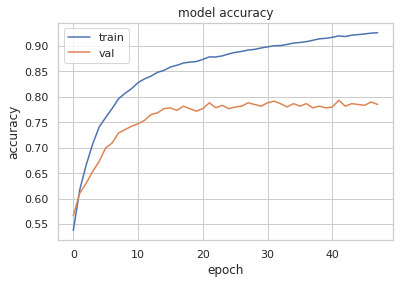

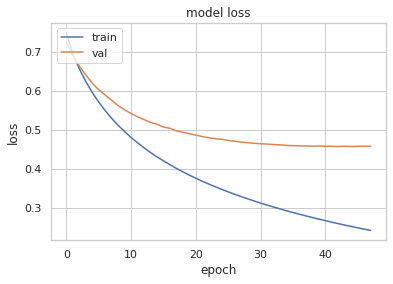

In [ ]:
# summarize history for accuracy
plt.plot(best_fitted.history['accuracy'])
plt.plot(best_fitted.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(best_fitted.history['loss'])
plt.plot(best_fitted.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

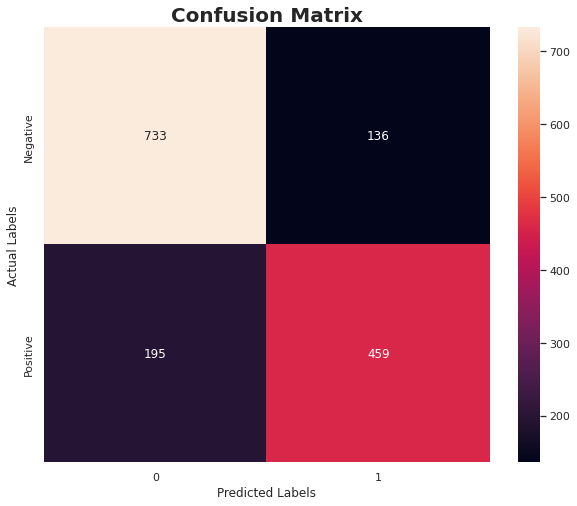

In [ ]:
labels= ["Negative", "Positive"]
cm = confusion_matrix(y_val, y_val_nn)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="g", ax=ax)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix", size=20, weight="bold")
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

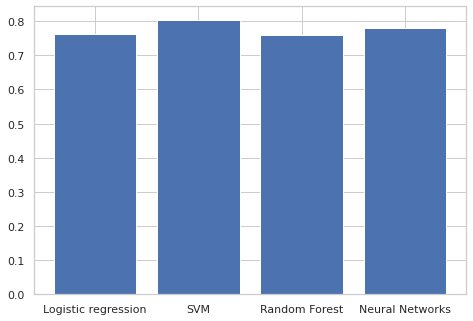

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Logistic regression', 'SVM', 'Random Forest', 'Neural Networks']
best_scores = [f1_score_lr, f1_score_svc, f1_score_rf, best]
ax.bar(models, best_scores)
plt.show()

In [ ]:
#define a scaler
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_val_count)
X_train_scl = scaler.transform(X_train_val_count)
X_test_scl = scaler.transform(X_test_count)
X_train_scl = X_train_scl.toarray()
print(X_train_scl.shape)
print(Y_train_val.shape)
y_train_cat = to_categorical(Y_train_val, num_classes)
print(y_train_cat.shape)
print(X_test_scl.shape)

(7613, 2000)
(7613, 1)
(7613, 2)
(3263, 2000)


In [ ]:
m = MLP_definer(n_layers = n_layers_best)
final = m.fit(X_train_scl, y_train_cat, epochs=500, batch_size=256, verbose=0, validation_split=0.1, callbacks = [es])
y_test_pred = m.predict(X_test_scl).argmax(axis = 1) 



Epoch 00046: early stopping


In [ ]:
download_predictions_to_file(X_test_id, y_test_pred)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>